# Dependências usadas


In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests

# Imagens usadas


Vamos usar as imagens disponíveis no site do professor Helio.


In [2]:
baboon_request = requests.get("https://www.ic.unicamp.br/~helio/imagens_png/baboon.png")

with open("baboon.png", "wb") as file:
    file.write(baboon_request.content)

baboon = cv2.imread("baboon.png", -1)

In [3]:
baboonp_request = requests.get(
    "https://www.ic.unicamp.br/~helio/imagens_png/baboon_perspectiva.png"
)

with open("baboon_perspectiva.png", "wb") as file:
    file.write(baboonp_request.content)

baboon_perspectiva = cv2.imread("baboon_perspectiva.png", -1)

# Função usada pra mostrar as imagens


In [4]:
def show_images(img1, title1, img2, title2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1, cmap="gray")
    axs[0].set_title(title1)
    axs[0].axis("off")
    axs[1].imshow(img2, cmap="gray")
    axs[1].set_title(title2)
    axs[1].axis("off")
    plt.show()

# 1 - Projeção Perspectiva


A primeira tarefa que temos é aplicar uma projeção perspectiva na imagem `baboon_perspectiva`. Para isso, vamos usar a função `cv2.warpPerspective()` do OpenCV. Essa função recebe como parâmetros a imagem de entrada, a matriz de transformação e o tamanho da imagem de saída. A matriz de transformação é dada pela função `cv2.getPerspectiveTransform()`, que recebe como parâmetros os pontos de entrada da imagem original e os pontos de saída.


Um ponto que gostaria de ressaltar: eu tentei montar a matriz de transformação de perspectiva mas não conseguia fazer a imagem ficar correta, então deixei usando o `cv2`.


In [5]:
def perspective_projection(image, pontos_origem, pontos_destino):
    matrix = cv2.getPerspectiveTransform(pontos_origem, pontos_destino)

    output_image = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))
    return output_image

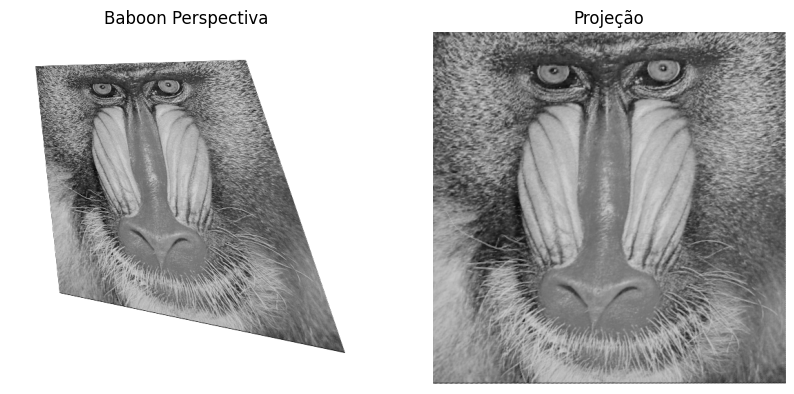

In [6]:
pontos_origem = np.float32([(37, 51), (342, 42), (485, 467), (73, 380)])
pontos_destino = np.float32([(0, 0), (511, 0), (511, 511), (0, 511)])

projecao = perspective_projection(baboon_perspectiva, pontos_origem, pontos_destino)

show_images(baboon_perspectiva, "Baboon Perspectiva", projecao, "Projeção")

Podemos ver que após a aplicação da projeção perspectiva, a imagem ficou alinhada da mesma forma que a imagem `baboon`.


# 2 - Transformações Geométricas


## Rotação de Imagens


O nosso objetivo agora é rotacionar imagens em determinados ângulos. Para isso, definimos uma função `rotate_image`. Essa função transforma o ângulo desejado para radianos, calcula o seno e cosseno e também o centro da imagem, para podermos fazer a rotação. Após isso, iteramos a imagem subtraindo o centro da imagem e multiplicando pela matriz de rotação vista em aula. Por fim, somamos o centro da imagem novamente, e vemos se o valor não ultrapassou as bordas.


In [7]:
def rotate_image(img, ang):
    rads = np.radians(ang)

    cos = np.cos(rads)
    sin = np.sin(rads)

    img_rotated = np.zeros(img.shape, dtype=np.uint8)

    width = img.shape[1]
    height = img.shape[0]

    center = (width // 2, height // 2)

    for i in range(height):
        for j in range(width):
            x = i - center[0]
            y = j - center[1]

            y1 = round(x * cos + y * sin)
            x1 = round(-x * sin + y * cos)

            x1 += center[0]
            y1 += center[1]

            if x1 >= 0 and x1 < img.shape[0] and y1 >= 0 and y1 < img.shape[1]:
                img_rotated[i, j] = img[y1, x1]

    return img_rotated

Aqui podemos ver a imagem rotacionada em 45.5 graus, mostrando que a rotação também pode ser feito com valores em ponto flutuante. Podemos ver que a imagem ficou com um espaço vazio, pois a imagem original era quadrada e a imagem rotacionada não preenche os espaços vazios.


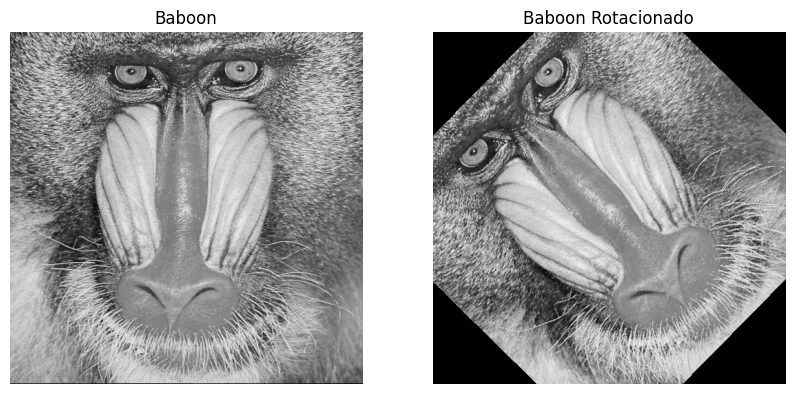

In [8]:
rotation_angle = 45.5  # Modifique para rotacionar a imagem no ângulo desejado

img_rotated = rotate_image(baboon, rotation_angle)

show_images(baboon, "Baboon", img_rotated, "Baboon Rotacionado")

## 2.1 - Interpolação pelo Vizinho Mais Próximo


A interpolação pelo vizinho mais próximo é a mais simples de ser implementada. Nela o valor do pixel novo é definido pelo pixel que estiver mais próximo do pixel original. Para isso, definimos uma função `nearest_neighbor` que recebe como parâmetros a imagem e o ponto que queremos interpolar. Essa função retorna o valor do pixel mais próximo do pixel original.


In [9]:
def nearest_neighbor(img, x, y):
    return img[round(y), round(x)]

## 2.2 - Interpolação Bilinear


A interpolação bilinear é um pouco mais complexa, pois usa uma média ponderada de distância dos quatro vizinhos mais próximos. Para isso, definimos uma função `bilinear_interpolation` que recebe como parâmetros a imagem e o ponto que queremos interpolar. Usamos a fórmula de interpolação vista em aula para calcular o valor do pixel e retornamos ele.


In [10]:
def bilinear_interpolation(img, x, y):
    x1 = int(x)
    y1 = int(y)
    x2 = x1 + 1
    y2 = y1 + 1

    if x2 >= img.shape[1]:
        x2 = x1
    if y2 >= img.shape[0]:
        y2 = y1

    dx = x - x1
    dy = y - y1

    f11 = img[y1, x1]
    f12 = img[y2, x1]
    f21 = img[y1, x2]
    f22 = img[y2, x2]

    return (
        (1 - dx) * (1 - dy) * f11
        + dx * (1 - dy) * f21
        + (1 - dx) * dy * f12
        + dx * dy * f22
    )

## 2.3 - Interpolação Bicúbica


A interpoalção bicúbica usa uma vizinha de 4x4 ao redor do ponto em questão. Aqui utilizamos a função `bicubic_interpolation`, usando as funções `P_function` e `R_function` como auxiliares.


In [11]:
def P_function(t):
    return t if t > 0 else 0


def R_function(s):
    return (
        P_function(s + 2) ** 3
        - 4 * P_function(s + 1) ** 3
        + 6 * P_function(s) ** 3
        - 4 * P_function(s - 1) ** 3
    ) / 6


def bicubic_interpolation(img, x, y):
    x1 = int(x)
    y1 = int(y)

    dx = x - x1
    dy = y - y1

    new_pixel = 0
    for m in range(-1, 3):
        for n in range(-1, 3):
            new_pixel += R_function(m - dx) * R_function(dy - n) * img[y1 + n, x1 + m]

    return new_pixel

## 2.4 - Interpolação por Polinômio de Lagrange


Este método de interpolação é um dos mais complexos, pois usa uma vizinhança de 4x4, e tenta achar um polinômio que passe por todos os pontos. Definimos a função `polynomial_interpolation` e a função auxiliar `L_function`.


In [12]:
def L_function(img, n, dx, x, y):
    result = (-dx * (dx - 1) * (dx - 2) * img[y + n - 2, x - 1]) / 6
    result += ((dx + 1) * (dx - 1) * (dx - 2) * img[y + n - 2, x]) / 2
    result += (-dx * (dx + 1) * (dx - 2) * img[y + n - 2, x + 1]) / 2
    result += (dx * (dx + 1) * (dx - 1) * img[y + n - 2, x + 2]) / 6

    return result


def polynomial_interpolation(img, x, y):
    x1 = int(x)
    y1 = int(y)

    dx = x - x1
    dy = y - y1

    new_pixel = (L_function(img, 1, dx, x1, y1) * -dy * (dy - 1) * (dy - 2)) / 6
    new_pixel += (L_function(img, 2, dx, x1, y1) * (dy + 1) * (dy - 1) * (dy - 2)) / 2
    new_pixel += (L_function(img, 3, dx, x1, y1) * -dy * (dy + 1) * (dy - 2)) / 2
    new_pixel += (L_function(img, 4, dx, x1, y1) * dy * (dy + 1) * (dy - 1)) / 6

    return new_pixel

## Lógica por trás da escolha da interpolação


Aqui eu defini uma função `scale_image` que recebe como parâmetros a imagem, o fator de escala e o tipo de interpolação. Essa função retorna a imagem escalada. Para isso, primeiro calculamos o tamanho da imagem de saída, e depois iteramos a imagem de saída, calculando o ponto correspondente na imagem de entrada. Após isso, verificamos qual o tipo de interpolação e chamamos a função correspondente. Por fim, retornamos a imagem de saída escalada.


In [13]:
methods = {
    "nearest": nearest_neighbor,
    "bilinear": bilinear_interpolation,
    "bicubic": bicubic_interpolation,
    "polynomial": polynomial_interpolation,
}


def scale_image(img, scale_factor, method):
    height = img.shape[0]
    width = img.shape[1]

    img_scaled = np.zeros(img.shape, dtype=np.uint8)

    for y_out in range(height):
        for x_out in range(width):
            x_in = x_out / scale_factor
            y_in = y_out / scale_factor

            img_scaled[y_out, x_out] = methods[method](img, x_in, y_in)

    return img_scaled

Aqui você pode definir o fator de escala e o tipo de método a ser utilizado. Novamente, coloquei um valor em ponto flutuante pra mostrar que funciona.


In [14]:
scale_factor = 2.5  # Mude o valor para o fator de escala desejado
method = "nearest"  # 'nearest', 'bilinear', 'bicubic', 'polynomial'

Resultado:


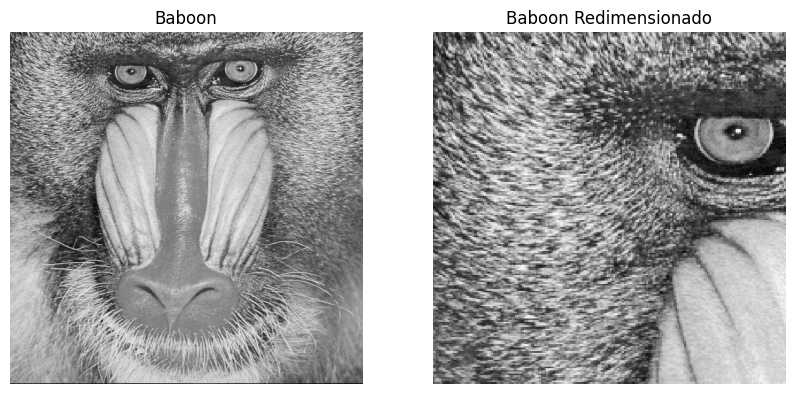

In [15]:
show_images(
    baboon, "Baboon", scale_image(baboon, scale_factor, method), "Baboon Redimensionado"
)

# Análise dos métodos de interpolação


Ao aumentarmos o fator de escala, percebemos que interpolações mais complexas resultam em imagens mais nítidas, mais suavez, com menos ruídos. Isso acontece pois as interpolações mais complexas usam mais pontos ou aproximações melhores para calcular o valor do pixel. Por exemplo, a interpolação pelo vizinho mais próximo usa apenas um ponto, enquanto a interpolação bicúbica usa 16 pontos.


In [16]:
scale_factor = 6

Aqui está uma comparação entre os diferentes tipos de interpolação, com fator de escala 6.


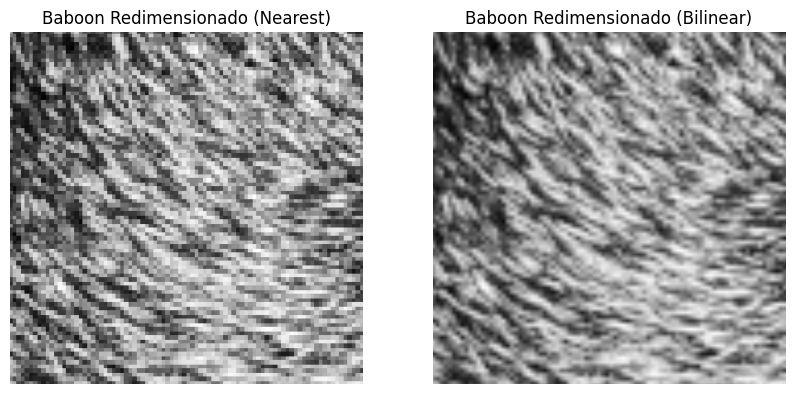

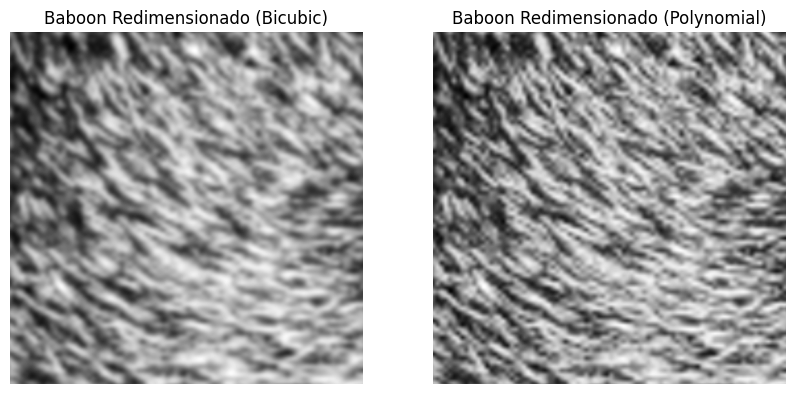

In [17]:
show_images(
    scale_image(baboon, scale_factor, "nearest"),
    "Baboon Redimensionado (Nearest)",
    scale_image(baboon, scale_factor, "bilinear"),
    "Baboon Redimensionado (Bilinear)",
)
show_images(
    scale_image(baboon, scale_factor, "bicubic"),
    "Baboon Redimensionado (Bicubic)",
    scale_image(baboon, scale_factor, "polynomial"),
    "Baboon Redimensionado (Polynomial)",
)

Para efeito de curiosidade, temos aqui uma comparação entre os tempo de execução de cada interpolação, com fator de escala 6. Perecebemos que a interpolação bicúbica é a mais lenta, demorando 11s, enquanto a interpolação pelo vizinho mais próximo é a mais rápida, na escala dos milissegundos.


In [18]:
%%time
a = scale_image(baboon, scale_factor, "nearest")

CPU times: user 82.9 ms, sys: 0 ns, total: 82.9 ms
Wall time: 82.8 ms


In [19]:
%%time
a = scale_image(baboon, scale_factor, "bilinear")

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s


In [20]:
%%time
a = scale_image(baboon, scale_factor, "bicubic")

CPU times: user 11.2 s, sys: 57 µs, total: 11.2 s
Wall time: 11.2 s


In [21]:
%%time
a = scale_image(baboon, scale_factor, "polynomial")

CPU times: user 5.41 s, sys: 121 µs, total: 5.41 s
Wall time: 5.41 s
